# Addressing New York Property Tax Challenge With Unsupervised Learning Methodology

The notebook showcases a forensic-type analysis to detect anomalies in a dataset, primarily focusing on unusual property valuations. It starts with data cleaning, including exclusions and imputation. As correlations and high dimensionality pose challenges, Principal Component Analysis (PCA) is employed to address these issues. Two fraud detection algorithms, one based on Minkowski distance from the origin and the other utilizing a simple autoencoder with reproduction error as the fraud score, are applied. To determine the final score, the ranked scores from both methods are averaged. The records are then sorted based on this final score, and the top records are explored. A heat map of variable z-scores aids in identifying which variables contribute to the high scores. The problem is presented as a demonstration of unsupervised fraud model building, using realistic data. 


The data can be found here: https://data.cityofnewyork.us/Housing-Development/Property-Valuation-and-Assessment-Data/rgy2-tti8

In [1]:
# load the libraries and APIs
from sklearn.neural_network import MLPRegressor
import pandas as pd
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
%matplotlib inline

/Users/lily/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
data = pd.read_csv('NY property data.csv')
NY_data_orig = data.copy()
data.shape

(1070994, 32)

In [3]:
data.dtypes

RECORD        int64
BBLE         object
BORO          int64
BLOCK         int64
LOT           int64
EASEMENT     object
OWNER        object
BLDGCL       object
TAXCLASS     object
LTFRONT       int64
LTDEPTH       int64
EXT          object
STORIES     float64
FULLVAL     float64
AVLAND      float64
AVTOT       float64
EXLAND      float64
EXTOT       float64
EXCD1       float64
STADDR       object
ZIP         float64
EXMPTCL      object
BLDFRONT      int64
BLDDEPTH      int64
AVLAND2     float64
AVTOT2      float64
EXLAND2     float64
EXTOT2      float64
EXCD2       float64
PERIOD       object
YEAR         object
VALTYPE      object
dtype: object

In [4]:
data.head()

,RECORD,BBLE,BORO,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,...,BLDFRONT,BLDDEPTH,AVLAND2,AVTOT2,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE
0,1,1000010101,1,1,101,NaN,U S GOVT LAND & BLDGS,P7,4,500,...,0,0,3775500.0,8613000.0,3775500.0,8613000.0,NaN,FINAL,2010/11,AC-TR
1,2,1000010201,1,1,201,NaN,U S GOVT LAND & BLDGS,Z9,4,27,...,0,0,11111400.0,80690400.0,11111400.0,80690400.0,NaN,FINAL,2010/11,AC-TR
2,3,1000020001,1,2,1,NaN,DEPT OF GENERAL SERVI,Y7,4,709,...,709,564,32321790.0,40179510.0,32321790.0,40179510.0,NaN,FINAL,2010/11,AC-TR
3,4,1000020023,1,2,23,NaN,DEPARTMENT OF BUSINES,T2,4,793,...,85,551,13644000.0,15750000.0,13644000.0,15750000.0,NaN,FINAL,2010/11,AC-TR
4,5,1000030001,1,3,1,NaN,PARKS AND RECREATION,Q1,4,323,...,89,57,106348680.0,107758350.0,106348680.0,107758350.0,NaN,FINAL,2010/11,AC-TR


## Remove benign properties with extreme values
Governmental and organizational properties are usually benign properties but with extremely large values on sizes, values, etc. These properties are not what we want to focus on and introduce noise to our analysis. So the first step is to remove governmental and organizational properties from the records.<br> 
<br>
We look at the most frequent owners and figure out and add the governmental and organizational ones to the remove list. Besides, we will add any other known governments and organizations to the list as well.<br>
<br>
If you have an existing list of governments and organizations for your dataset or use NLP, it can lead to a better result.

In [5]:
# look at the most frequent owners
remove_list = data['OWNER'].value_counts().head(20).index.tolist()
remove_list

['PARKCHESTER PRESERVAT',
 'PARKS AND RECREATION',
 'DCAS',
 'HOUSING PRESERVATION',
 'CITY OF NEW YORK',
 'DEPT OF ENVIRONMENTAL',
 'BOARD OF EDUCATION',
 'NEW YORK CITY HOUSING',
 'CNY/NYCTA',
 'NYC HOUSING PARTNERSH',
 'YORKVILLE TOWERS ASSO',
 'DEPARTMENT OF BUSINES',
 'DEPT OF TRANSPORTATIO',
 'MTA/LIRR',
 'PARCKHESTER PRESERVAT',
 'MH RESIDENTIAL 1, LLC',
 '434 M LLC',
 'LINCOLN PLAZA ASSOCIA',
 'DEUTSCHE BANK NATIONA',
 '561 11TH AVENUE TMG L']

In [6]:
# remove some of these most frequent owners and add those known governments and organizations to the list
remove_list.remove('YORKVILLE TOWERS ASSO')
remove_list.remove('434 M LLC')
remove_list.remove('DEUTSCHE BANK NATIONA')
remove_list.remove('561 11TH AVENUE TMG L')
remove_list.append('UNITED STATES OF AMER')
remove_list.append('U S GOVERNMENT OWNRD')
remove_list.append('THE CITY OF NEW YORK')
remove_list.append('NYS URBAN DEVELOPMENT')
remove_list.append('NYS DEPT OF ENVIRONME')
remove_list.append('CULTURAL AFFAIRS')
remove_list.append('DEPT OF GENERAL SERVI')
remove_list.append('DEPT RE-CITY OF NY')
remove_list.append('NY STATE PUBLIC WORKS')
remove_list.append('NYC DEPT OF HIGHWAYS')
remove_list.append("NYC DEP'T OF HIGHWAYS")
remove_list.append('CITY WIDE ADMINISTRAT')
remove_list.append('DEPT OF PUBLIC WORKS')
remove_list.append('NEW YORK CITY')
remove_list.append('THE PORT OFNY & NJ')
remove_list.append('NYC DEPT OF PUB WORKS')
remove_list.append('NEW YORK STATE DEPART')
remove_list.append('CITY AND NON-CITY OWN')

In [7]:
remove_list

['PARKCHESTER PRESERVAT',
 'PARKS AND RECREATION',
 'DCAS',
 'HOUSING PRESERVATION',
 'CITY OF NEW YORK',
 'DEPT OF ENVIRONMENTAL',
 'BOARD OF EDUCATION',
 'NEW YORK CITY HOUSING',
 'CNY/NYCTA',
 'NYC HOUSING PARTNERSH',
 'DEPARTMENT OF BUSINES',
 'DEPT OF TRANSPORTATIO',
 'MTA/LIRR',
 'PARCKHESTER PRESERVAT',
 'MH RESIDENTIAL 1, LLC',
 'LINCOLN PLAZA ASSOCIA',
 'UNITED STATES OF AMER',
 'U S GOVERNMENT OWNRD',
 'THE CITY OF NEW YORK',
 'NYS URBAN DEVELOPMENT',
 'NYS DEPT OF ENVIRONME',
 'CULTURAL AFFAIRS',
 'DEPT OF GENERAL SERVI',
 'DEPT RE-CITY OF NY',
 'NY STATE PUBLIC WORKS',
 'NYC DEPT OF HIGHWAYS',
 "NYC DEP'T OF HIGHWAYS",
 'CITY WIDE ADMINISTRAT',
 'DEPT OF PUBLIC WORKS',
 'NEW YORK CITY',
 'THE PORT OFNY & NJ',
 'NYC DEPT OF PUB WORKS',
 'NEW YORK STATE DEPART',
 'CITY AND NON-CITY OWN']

In [8]:
property_data = data[~data['OWNER'].isin(remove_list)].reset_index(drop=True)
numrecs = len(property_data)

In [9]:
property_data.describe()

,RECORD,BORO,BLOCK,LOT,LTFRONT,LTDEPTH,STORIES,FULLVAL,AVLAND,AVTOT,...,EXTOT,EXCD1,ZIP,BLDFRONT,BLDDEPTH,AVLAND2,AVTOT2,EXLAND2,EXTOT2,EXCD2
count,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.002832e+06,1.046516e+06,1.046516e+06,1.046516e+06,...,1.046516e+06,625079.000000,1.024979e+06,1.046516e+06,1.046516e+06,2.671950e+05,2.672010e+05,8.217100e+04,1.191700e+05,92912.000000
mean,5.370414e+05,3.221406e+00,4.757496e+03,3.499131e+02,3.517651e+01,8.789226e+01,4.954916e+00,8.143381e+05,6.700725e+04,1.992444e+05,...,6.120476e+04,1586.100910,1.092762e+04,2.315051e+01,4.023638e+01,2.004894e+05,6.460639e+05,1.848366e+05,4.839392e+05,1363.645611
std,3.080583e+05,1.198854e+00,3.677586e+03,8.259315e+02,5.808096e+01,6.500050e+01,8.361619e+00,6.448236e+06,2.023430e+06,5.399856e+06,...,4.909705e+06,1387.698506,5.278771e+02,3.477550e+01,4.068794e+01,3.686022e+06,1.015098e+07,6.088665e+06,1.387607e+07,1094.210697
min,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,1010.000000,1.000100e+04,0.000000e+00,0.000000e+00,3.000000e+00,3.000000e+00,1.000000e+00,7.000000e+00,1011.000000
25%,2.731068e+05,3.000000e+00,1.542000e+03,2.300000e+01,1.900000e+01,8.200000e+01,2.000000e+00,3.120000e+05,9.442000e+03,1.866200e+04,...,0.000000e+00,1017.000000,1.031400e+04,1.600000e+01,2.700000e+01,6.169000e+03,3.688000e+04,2.090000e+03,2.800000e+03,1017.000000
50%,5.389795e+05,3.000000e+00,4.079000e+03,4.900000e+01,2.500000e+01,1.000000e+02,2.000000e+00,4.500000e+05,1.374100e+04,2.546000e+04,...,1.620000e+03,1017.000000,1.121500e+04,2.000000e+01,4.000000e+01,2.043700e+04,8.226500e+04,2.632000e+03,3.919000e+04,1017.000000
75%,8.026112e+05,4.000000e+00,6.921000e+03,1.390000e+02,4.000000e+01,1.000000e+02,3.000000e+00,6.210000e+05,1.968000e+04,4.528500e+04,...,2.090000e+03,1017.000000,1.136400e+04,2.400000e+01,5.100000e+01,6.142750e+04,2.408360e+05,2.252000e+04,1.026908e+05,1017.000000
max,1.070994e+06,5.000000e+00,1.635000e+04,9.502000e+03,9.999000e+03,9.619000e+03,1.190000e+02,1.663775e+09,1.792809e+09,4.668309e+09,...,4.668309e+09,7170.000000,3.380300e+04,7.575000e+03,9.393000e+03,1.644454e+09,4.501180e+09,1.644454e+09,4.501180e+09,7160.000000


In [10]:
# this is how many records we removed
len(data) - len(property_data)

24478

## Data Cleansing

### Filling the missing value of ZIP

The data is basically sorted by zip. If the zip code before and after the missing zip are the same, fill in the missing zip with that value. If not, fill in the missing zip with the closest previous record's zip. 

In [11]:
# How many zips are missing? Replace NAN with 0 and count them.
missing_zips = np.where(pd.isnull(property_data['ZIP']))[0]
len(missing_zips)

21537

In [12]:
# If a zip is missing, and the before and after zips are the same, fill in the zip with that value
for i in range(len(missing_zips)):
    if(property_data.loc[missing_zips[i]+1,'ZIP'] == property_data.loc[missing_zips[i]-1,'ZIP']):
        property_data.loc[missing_zips[i],'ZIP'] = property_data.loc[missing_zips[i]-1,'ZIP']

In [13]:
# How many records' zip are still missing?
missing_zips = np.where(pd.isnull(property_data['ZIP']))[0]
len(missing_zips)

10114

In [14]:
# For the remaining missing zips, just fill in with the previous record's zip.
for i in range(len(missing_zips)):
    property_data.loc[missing_zips[i],'ZIP'] = property_data.loc[missing_zips[i]-1,'ZIP']

In [15]:
missing_zips = np.where(pd.isnull(property_data['ZIP']))[0]
len(missing_zips)

0

### Filling the missing and frivolous values in other fields

Besides zip code, there are 10 fields with missing values, 0 or 1 (which is highly impossible to be the right value, size, or price for a property, we assume all 0 and 1 are frivolous values). The methodology to fill in those missing values is to use the average of the field according to the tax class. If there are too many tax classes missing for a specific field, then use the global average to fill in the missing values.

In [16]:
# create functions for each type of field that needs data cleansing

# fields only with frivolous value 0 or only missing values
def with0(field_name):
    property_data[field_name] = property_data[field_name].replace(np.NaN, 0)
    temp = property_data[property_data[field_name]!=0]
    mean = temp.groupby('TAXCLASS')[field_name].mean()
    for index in mean.index:
        property_data.loc[(property_data[field_name]==0)&\
                          (property_data['TAXCLASS']==index),field_name]=mean[index]
        
    return mean


# fields with frivolous values 0 & 1
def with01(field_name):
    property_data.loc[property_data[field_name]==0,field_name]=np.nan
    property_data.loc[property_data[field_name]==1,field_name]=np.nan
    mean=property_data.groupby(property_data['TAXCLASS'])[field_name].mean()
    for index in mean.index:
        property_data.loc[(property_data[field_name].isnull())&\
                          (property_data['TAXCLASS']==index),field_name]=mean[index]
    
    return mean

In [17]:
# using the functions to conduct data imputation on representative fields

# with only frivolous value 0: FULLVAL, AVLAND, AVTOT
# with only missing values: STORIES 
mean_fullval = with0('FULLVAL')
mean_avland = with0('AVLAND')
mean_avtot = with0('AVTOT')
mean_stories = with0('STORIES')

# with frivolous values 0 & 1: LTFRONT, LTDEPTH, BLDDEPTH, BLDFRONT
mean_ltfront = with01('LTFRONT')
mean_ltdepth = with01('LTDEPTH')
mean_blddepth = with01('BLDDEPTH')
mean_bldfront = with01('BLDFRONT')

print(mean_fullval)
print(mean_avland)
print(mean_avtot)
print(mean_stories)
print(mean_ltfront)
print(mean_ltdepth)
print(mean_blddepth)
print(mean_bldfront)

TAXCLASS
1     5.700050e+05
1A    3.352942e+05
1B    3.741718e+05
1C    7.615359e+05
1D    2.233614e+07
2     8.005832e+05
2A    8.639066e+05
2B    1.254525e+06
2C    7.723556e+05
3     8.510005e+04
4     2.713604e+06
Name: FULLVAL, dtype: float64
TAXCLASS
1      14901.810481
1A      2247.472465
1B      9177.301542
1C      8225.658898
1D    709303.793103
2      88471.102578
2A     31370.740197
2B     54607.394911
2C     25638.080660
3      28135.636364
4     440646.291155
Name: AVLAND, dtype: float64
TAXCLASS
1     2.502541e+04
1A    1.437036e+04
1B    9.180997e+03
1C    2.898447e+04
1D    1.166866e+06
2     3.602638e+05
2A    7.963525e+04
2B    1.790961e+05
2C    1.170427e+05
3     3.829505e+04
4     1.267732e+06
Name: AVTOT, dtype: float64
TAXCLASS
1      2.111631
1A     1.656867
1B     4.000000
1C     3.052748
1D     1.068966
2     16.310549
2A     2.844032
2B     4.001635
2C     4.745047
3      1.000000
4      5.517525
Name: STORIES, dtype: float64
TAXCLASS
1      30.939123
1A     

In [18]:
# There are some fields that doesn't follow the pattern of our two functions
# We'll deal with them by the following part

# STORIES (with missing values)
# temp = property_data[property_data['STORIES'].isnull()]
# print('How many missing values (stories):',len(temp))
# mean_stories = property_data.groupby('TAXCLASS')['STORIES'].mean()
# print('How many 0s (stories):',len(property_data[property_data["STORIES"]==0]))
# # fill Nan with 0
# property_data['STORIES']=property_data['STORIES'].fillna(value =0)
# for index in mean_stories.index:
#     property_data.loc[(property_data['STORIES']==0)&\
#                       (property_data['TAXCLASS']==index),'STORIES']=mean_stories[index]
    
    
# AVLAND2, AVTOT2
mean_avland2 = with0("AVLAND2")
mean_avtot2 = with0("AVTOT2")
print(mean_avland2)
print(mean_avtot2)

# there are only 2 tax class for these two fields, we'd better keep the global mean to fill in the missing value
# We don't have the transitional value for 'FULLVAL'
# We assume FULLVAL2 = AVLAND2 + AVTOT2
property_data['AVLAND2'] = property_data['AVLAND2'].replace(np.NaN,0)
temp = property_data[property_data['AVLAND2']!=0]
mean_avland2 = temp['AVLAND2'].mean()

property_data['AVTOT2'] = property_data['AVTOT2'].replace(np.NaN,0)
temp = property_data[property_data['AVTOT2']!=0]
mean_avtot2 = temp['AVTOT2'].mean()

mean_fullval2 = mean_avland2 + mean_avtot2

property_data.loc[(property_data['AVLAND2']==0),'AVLAND2']=mean_avland2
property_data.loc[(property_data['AVTOT2']==0),'AVTOT2']=mean_avtot2
property_data['FULLVAL2'] = mean_fullval2

TAXCLASS
2     86713.904377
4    405354.701727
Name: AVLAND2, dtype: float64
TAXCLASS
2    3.495683e+05
4    1.179903e+06
Name: AVTOT2, dtype: float64


In [19]:
property_data.count()

RECORD      1046516
BBLE        1046516
BORO        1046516
BLOCK       1046516
LOT         1046516
EASEMENT       2762
OWNER       1014771
BLDGCL      1046516
TAXCLASS    1046516
LTFRONT     1046516
LTDEPTH     1046516
EXT          353364
STORIES     1046516
FULLVAL     1046516
AVLAND      1046516
AVTOT       1046516
EXLAND      1046516
EXTOT       1046516
EXCD1        625079
STADDR      1046053
ZIP         1046516
EXMPTCL       10467
BLDFRONT    1046516
BLDDEPTH    1046516
AVLAND2     1046516
AVTOT2      1046516
EXLAND2       82171
EXTOT2       119170
EXCD2         92912
PERIOD      1046516
YEAR        1046516
VALTYPE     1046516
FULLVAL2    1046516
dtype: int64

In [20]:
data = property_data.copy()
data.shape

(1046516, 33)

In [21]:
data.dtypes

RECORD        int64
BBLE         object
BORO          int64
BLOCK         int64
LOT           int64
EASEMENT     object
OWNER        object
BLDGCL       object
TAXCLASS     object
LTFRONT     float64
LTDEPTH     float64
EXT          object
STORIES     float64
FULLVAL     float64
AVLAND      float64
AVTOT       float64
EXLAND      float64
EXTOT       float64
EXCD1       float64
STADDR       object
ZIP         float64
EXMPTCL      object
BLDFRONT    float64
BLDDEPTH    float64
AVLAND2     float64
AVTOT2      float64
EXLAND2     float64
EXTOT2      float64
EXCD2       float64
PERIOD       object
YEAR         object
VALTYPE      object
FULLVAL2    float64
dtype: object

In [22]:
# convert ZIP to a string rather than a float
# We call the first three digits of the zip zip3
data['ZIP'] = data['ZIP'].astype(str)
data['zip3'] = data['ZIP'].str[:3]

In [23]:
cols = data.columns
print(cols)

Index(['RECORD', 'BBLE', 'BORO', 'BLOCK', 'LOT', 'EASEMENT', 'OWNER', 'BLDGCL',
       'TAXCLASS', 'LTFRONT', 'LTDEPTH', 'EXT', 'STORIES', 'FULLVAL', 'AVLAND',
       'AVTOT', 'EXLAND', 'EXTOT', 'EXCD1', 'STADDR', 'ZIP', 'EXMPTCL',
       'BLDFRONT', 'BLDDEPTH', 'AVLAND2', 'AVTOT2', 'EXLAND2', 'EXTOT2',
       'EXCD2', 'PERIOD', 'YEAR', 'VALTYPE', 'FULLVAL2', 'zip3'],
      dtype='object')


## Create Variables

The project aims to find out the properties with abnormal data that might affect tax payments. Therefore, we create variables based on property size and price (value). We want to capture both extremely small and large values for each variable for the sake of better understanding and detecting the anomaly.

Variables we created for the further analysis:
- Value per size & Inverse: <br>
The ratio (and inversed ratio) of actual values of the property (FULLVAL, AVLAND, AVTOT) divided by calculated variables for property size as follows:
    -	lotarea = LTFRONT * LTDEPTH (Lot floor area)
    -	bldarea = BLDFRONT * BLDDEPTH (Building floor area)
    -	bldvol = bldarea * STORIES (Building total area)
<br>
<br>
- Relative value per size:<br>
The relative value of Value per Size / Inverse of Value per Size over the representative average ratio of the property group (group by ZIP, zip3, or TAXCLASS).
<br>

- Relative value ratio:<br>
The ratio between FULLVAL and AVLAND+AVTOT (Find whether the full value is the same or nearly the same as the land value plus property value.
<br>

- Ratio of actual/transitional price & Inverse:<br>
The ratio (and inverse ratio) between the actual values (FULLVAL, AVLAND, AVTOT) and the transitional values (FULLVAL2, AVLAND2, AVTOT2), to help detect whether there are some manipulations on the properties’ market prices.
<br>

- Relative Ratio of Actual / Transitional Price:<br>
The relative value of Ratio of Actual / Transitional Price & Inverse of Ratio of Actual / Transitional Price over the representative average ratio of the property group (group by ZIP, zip3, or TAXCLASS). 

In [24]:
# lot size
data['ltsize'] = data['LTFRONT'] * data['LTDEPTH']
# building floor area
data['bldsize'] = data['BLDFRONT'] * data['BLDDEPTH']
# building total area
data['bldvol'] = data['bldsize'] * data['STORIES']

In [25]:
# Relative value per size
data['fullval_ltsize'] = data['FULLVAL'] / data['ltsize']
data['fullval_bldsize'] = data['FULLVAL'] / data['bldsize']
data['fullval_bldvol'] = data['FULLVAL'] / data['bldvol']
data['avland_ltsize'] = data['AVLAND'] / data['ltsize']
data['avland_bldsize'] = data['AVLAND'] / data['bldsize']
data['avland_bldvol'] = data['AVLAND'] / data['bldvol']
data['avtot_ltsize'] = data['AVTOT'] / data['ltsize']
data['avtot_bldsize'] = data['AVTOT'] / data['bldsize']
data['avtot_bldvol'] = data['AVTOT'] / data['bldvol']

# Ratio of actual/transitional price
data['avland_avland2'] = data['AVLAND']/data['AVLAND2']
data['avtot_avtot2'] = data['AVTOT']/data['AVTOT2']
data['fullval_fullval2'] = data['FULLVAL']/data['FULLVAL2']

In [26]:
# data['r1'] = data['FULLVAL'] / data['ltsize']
# data['r2'] = data['FULLVAL'] / data['bldsize']
# data['r3'] = data['FULLVAL'] / data['bldvol']
# data['r4'] = data['AVLAND'] / data['ltsize']
# data['r5'] = data['AVLAND'] / data['bldsize']
# data['r6'] = data['AVLAND'] / data['bldvol']
# data['r7'] = data['AVTOT'] / data['ltsize']
# data['r8'] = data['AVTOT'] / data['bldsize']
# data['r9'] = data['AVTOT'] / data['bldvol']

# data['new_var_r1'] = data['AVLAND']/data['AVLAND2']
# data['new_var_r2'] = data['AVTOT']/data['AVTOT2']
# data['new_var_r3'] = data['FULLVAL']/data['FULLVAL2']

In [27]:
data.columns[37:]

Index(['fullval_ltsize', 'fullval_bldsize', 'fullval_bldvol', 'avland_ltsize',
       'avland_bldsize', 'avland_bldvol', 'avtot_ltsize', 'avtot_bldsize',
       'avtot_bldvol', 'avland_avland2', 'avtot_avtot2', 'fullval_fullval2'],
      dtype='object')

In [28]:
# add in the inverse of all primary variables
epsilon = .01
for col in data.columns[37:]:
    data[col+'_inv'] = 1/(data[col] + epsilon)

In [29]:
# Relative ratios by taxclass and zip
vars18 =['fullval_ltsize', 'fullval_bldsize', 'fullval_bldvol', 'avland_ltsize',
       'avland_bldsize', 'avland_bldvol', 'avtot_ltsize', 'avtot_bldsize','avtot_bldvol',
       'avland_avland2', 'avtot_avtot2', 'fullval_fullval2',
       'fullval_ltsize_inv', 'fullval_bldsize_inv', 'fullval_bldvol_inv', 'avland_ltsize_inv',
       'avland_bldsize_inv', 'avland_bldvol_inv', 'avtot_ltsize_inv', 'avtot_bldsize_inv',
       'avtot_bldvol_inv','avland_avland2_inv', 'avtot_avtot2_inv', 'fullval_fullval2_inv']

zip5_mean = data.groupby('ZIP')[vars18].mean()
zip3_mean = data.groupby('zip3')[vars18].mean()
taxclass_mean = data.groupby('TAXCLASS')[vars18].mean()
data = data.join(zip5_mean, on='ZIP', rsuffix='_zip5')
data = data.join(zip3_mean, on='zip3', rsuffix='_zip3')
data = data.join(taxclass_mean, on='TAXCLASS', rsuffix='_taxclass')
rsuffix = ['_zip5','_zip3','_taxclass']
for var in vars18:
    for r in rsuffix:
        data[str(var)+r] = data[var] / data[str(var)+r]

In [30]:
# Relative value ratio
data['value_ratio'] = data['FULLVAL']/(data['AVLAND']+data['AVTOT'])
data['value_ratio'] = data['value_ratio']/data['value_ratio'].mean()
data['value_ratio'] = np.where(data['value_ratio'] < 1, 1/(data['value_ratio']+epsilon), data['value_ratio'])

In [31]:
data.head().transpose()

,0,1,2,3,4
RECORD,1,2,9,10,11
BBLE,1000010101,1000010201,1000041001,1000041002,1000041003
BORO,1,1,1,1,1
BLOCK,1,1,4,4,4
LOT,101,201,1001,1002,1003
...,...,...,...,...,...
avtot_bldvol_inv_taxclass,0.000934,0.000103,0.045842,0.031735,0.017076
avland_avland2_inv_taxclass,0.659919,0.574152,0.737795,0.737795,0.737795
avtot_avtot2_inv_taxclass,0.641145,0.663058,0.825431,0.825432,0.822059
fullval_fullval2_inv_taxclass,0.003395,0.000375,0.018386,0.012731,0.006851


In [32]:
data.columns

Index(['RECORD', 'BBLE', 'BORO', 'BLOCK', 'LOT', 'EASEMENT', 'OWNER', 'BLDGCL',
       'TAXCLASS', 'LTFRONT',
       ...
       'avland_ltsize_inv_taxclass', 'avland_bldsize_inv_taxclass',
       'avland_bldvol_inv_taxclass', 'avtot_ltsize_inv_taxclass',
       'avtot_bldsize_inv_taxclass', 'avtot_bldvol_inv_taxclass',
       'avland_avland2_inv_taxclass', 'avtot_avtot2_inv_taxclass',
       'fullval_fullval2_inv_taxclass', 'value_ratio'],
      dtype='object', length=134)

In [33]:
# save the original record number -- 
# since we drop some records the default index number changed
save_record = data['RECORD']
save_record.head()

0     1
1     2
2     9
3    10
4    11
Name: RECORD, dtype: int64

In [34]:
# drop original features, keep our variables only
dropcols = ['RECORD','BBLE', 'BORO', 'BLOCK', 'LOT', 'EASEMENT',
       'OWNER', 'BLDGCL', 'TAXCLASS', 'LTFRONT', 'LTDEPTH', 'EXT', 'STORIES',
       'FULLVAL', 'AVLAND', 'AVTOT', 'EXLAND', 'EXTOT', 'EXCD1', 'STADDR',
       'ZIP', 'EXMPTCL', 'BLDFRONT', 'BLDDEPTH', 'AVLAND2', 'AVTOT2',
       'EXLAND2', 'EXTOT2', 'EXCD2', 'PERIOD', 'YEAR', 'VALTYPE', 'zip3','ltsize','bldsize','bldvol','FULLVAL2']
data = data.drop(columns = dropcols)
data.shape

(1046516, 97)

In [35]:
data.head().transpose()

,0,1,2,3,4
fullval_ltsize,40.917782,57777.406626,386.588395,558.693624,1038.804619
fullval_bldsize,3996.868587,36195.940760,736.761464,1064.760189,1979.757338
fullval_bldvol,724.395187,6560.176972,14.735229,21.295204,39.595147
avland_ltsize,8.079350,4266.226465,62.337391,90.089449,94.815422
avland_bldsize,789.194776,2672.672406,118.802810,171.692774,180.699549
...,...,...,...,...,...
avtot_bldvol_inv_taxclass,0.000934,0.000103,0.045842,0.031735,0.017076
avland_avland2_inv_taxclass,0.659919,0.574152,0.737795,0.737795,0.737795
avtot_avtot2_inv_taxclass,0.641145,0.663058,0.825431,0.825432,0.822059
fullval_fullval2_inv_taxclass,0.003395,0.000375,0.018386,0.012731,0.006851


In [36]:
data.describe()

,fullval_ltsize,fullval_bldsize,fullval_bldvol,avland_ltsize,avland_bldsize,avland_bldvol,avtot_ltsize,avtot_bldsize,avtot_bldvol,avland_avland2,...,avland_ltsize_inv_taxclass,avland_bldsize_inv_taxclass,avland_bldvol_inv_taxclass,avtot_ltsize_inv_taxclass,avtot_bldsize_inv_taxclass,avtot_bldvol_inv_taxclass,avland_avland2_inv_taxclass,avtot_avtot2_inv_taxclass,fullval_fullval2_inv_taxclass,value_ratio
count,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,...,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06
mean,2.135038e+02,5.362375e+02,2.439317e+02,1.045370e+01,2.271059e+01,9.972084e+00,2.678511e+01,5.032958e+01,1.898083e+01,3.498411e-01,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,3.098705e+00
std,5.285099e+02,1.015744e+03,4.865839e+02,6.942780e+01,3.734493e+02,1.734902e+02,2.016225e+02,9.301625e+02,3.234246e+02,5.892522e-01,...,1.868409e+00,2.724964e+00,1.832908e+00,2.843491e+00,4.189073e+00,2.589571e+00,1.803111e+00,1.625182e+00,9.536670e-01,1.780671e+01
min,3.920017e-04,7.470782e-04,8.983394e-05,8.333333e-06,2.096125e-04,1.038033e-05,8.333333e-06,3.062474e-04,6.049251e-05,5.035897e-06,...,1.552935e-05,1.431471e-06,1.275709e-06,2.003892e-05,1.773437e-06,1.047473e-06,2.513320e-04,5.556267e-04,4.368548e-05,9.900999e-01
25%,7.637535e+01,2.122355e+02,8.274126e+01,2.356020e+00,6.215246e+00,2.021085e+00,5.284000e+00,1.747868e+01,7.100314e+00,5.740923e-02,...,4.078248e-01,4.785647e-01,4.916828e-01,4.487750e-01,5.541471e-01,5.331771e-01,7.253281e-01,7.534209e-01,6.095541e-01,1.111527e+00
50%,1.529167e+02,5.000000e+02,2.391026e+02,4.598000e+00,1.498333e+01,7.148054e+00,8.581667e+00,2.698050e+01,1.267981e+01,8.025206e-02,...,7.197893e-01,7.551423e-01,7.553706e-01,7.339600e-01,7.910590e-01,7.890335e-01,8.394444e-01,8.988619e-01,8.969838e-01,1.272341e+00
75%,2.432000e+02,6.838915e+02,3.362573e+02,7.225959e+00,2.028715e+01,1.004388e+01,1.352896e+01,3.600364e+01,1.757576e+01,9.998476e-01,...,1.133427e+00,1.051929e+00,1.068727e+00,1.101834e+00,1.060792e+00,1.074389e+00,1.039887e+00,1.082133e+00,1.188212e+00,6.018453e+00
max,1.356802e+05,3.107425e+05,2.275000e+05,2.203231e+04,3.348421e+05,1.116140e+05,6.338662e+04,8.718980e+05,2.906327e+05,2.283371e+02,...,3.569719e+02,1.203888e+03,6.394555e+02,6.063542e+02,1.980945e+03,1.095921e+03,8.458879e+01,8.854747e+01,6.695783e+01,1.000512e+04


# Build Unsupervised Model (PCA)

This part includes deciding how many PCs we would love to keep for the final model, how to design the anomaly detection algorithms, how to decide the weight for each algorithm if you want to combine them, and also, tuning the parameters for the algorithms themselves.

In [37]:
# save a copy of all variables
data.to_csv('NY vars.csv', index=False)

In [38]:
# z-scale all the variables
data_zs = (data - data.mean()) / data.std()
data_zs_save = data_zs.copy()
data_zs.describe()

,fullval_ltsize,fullval_bldsize,fullval_bldvol,avland_ltsize,avland_bldsize,avland_bldvol,avtot_ltsize,avtot_bldsize,avtot_bldvol,avland_avland2,...,avland_ltsize_inv_taxclass,avland_bldsize_inv_taxclass,avland_bldvol_inv_taxclass,avtot_ltsize_inv_taxclass,avtot_bldsize_inv_taxclass,avtot_bldvol_inv_taxclass,avland_avland2_inv_taxclass,avtot_avtot2_inv_taxclass,fullval_fullval2_inv_taxclass,value_ratio
count,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,...,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06
mean,-4.987863e-14,-4.120539e-14,-4.213792e-15,-1.192801e-14,-1.523930e-15,6.895732e-16,-4.875373e-14,-2.857037e-15,-1.090882e-14,-1.854139e-13,...,2.369202e-14,1.611295e-14,-2.948667e-15,-2.263668e-15,2.379833e-14,-3.155178e-14,-6.172597e-13,5.726992e-14,7.763433e-13,3.903621e-14
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-4.039724e-01,-5.279251e-01,-5.013145e-01,-1.505693e-01,-6.081250e-02,-5.747917e-02,-1.328478e-01,-5.410804e-02,-5.868685e-02,-5.936949e-01,...,-5.352064e-01,-3.669768e-01,-5.455804e-01,-3.516733e-01,-2.387159e-01,-3.861640e-01,-5.544577e-01,-6.149739e-01,-1.048538e+00,-1.184163e-01
25%,-2.594624e-01,-3.189799e-01,-3.312695e-01,-1.166346e-01,-4.417025e-02,-4.582967e-02,-1.066404e-01,-3.531737e-02,-3.673350e-02,-4.962762e-01,...,-3.169409e-01,-1.913549e-01,-2.773283e-01,-1.938550e-01,-1.064324e-01,-1.802704e-01,-1.523322e-01,-1.517240e-01,-4.094153e-01,-1.115971e-01
50%,-1.146377e-01,-3.567583e-02,-9.924473e-03,-8.434234e-02,-2.069159e-02,-1.627775e-02,-9.028477e-02,-2.510215e-02,-1.948221e-02,-4.575104e-01,...,-1.499729e-01,-8.985721e-02,-1.334652e-01,-9.356105e-02,-4.987762e-02,-8.146776e-02,-8.904367e-02,-6.223185e-02,-1.080211e-01,-1.025660e-01
75%,5.618853e-02,1.453654e-01,1.897425e-01,-4.649066e-02,-6.489343e-03,4.138601e-04,-6.574734e-02,-1.540155e-02,-4.344369e-03,1.103104e+00,...,7.141198e-02,1.905684e-02,3.749616e-02,3.581319e-02,1.451196e-02,2.872642e-02,2.212128e-02,5.053764e-02,1.973556e-01,1.639690e-01
max,2.563182e+02,3.053981e+02,4.670439e+02,3.171908e+02,8.965594e+02,6.432875e+02,3.142499e+02,9.373068e+02,8.985515e+02,3.869094e+02,...,1.905214e+02,4.414327e+02,3.483293e+02,2.128912e+02,4.726452e+02,4.228196e+02,4.635810e+01,5.386934e+01,6.916232e+01,5.616993e+02


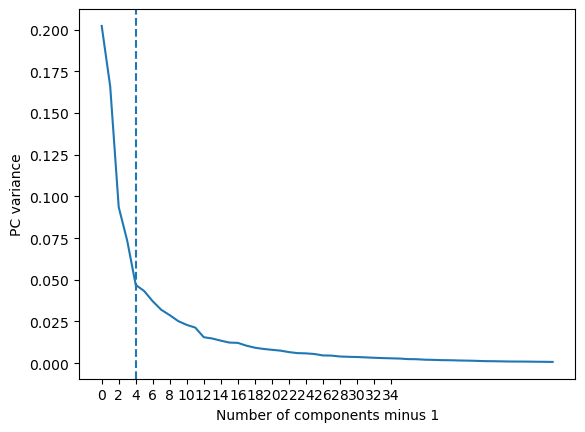

In [39]:
# run a PCA and look at the PC variance
pca = PCA(n_components =0.99, svd_solver = 'full')
pca.fit(data_zs)
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Number of components minus 1')
plt.ylabel('PC variance')
plt.xticks(np.arange(0, 36, step=2))
plt.axvline(x=4, linestyle='--')

(0.0, 1.0)

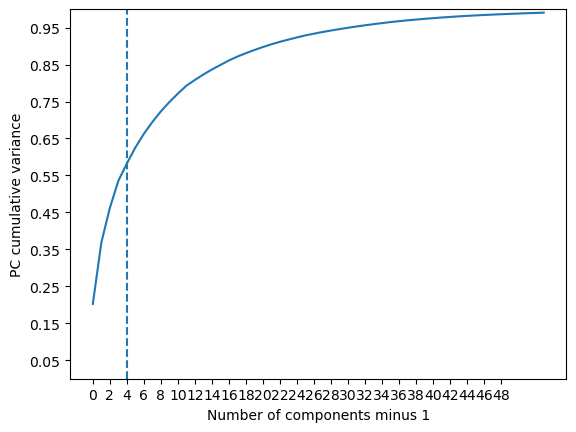

In [40]:
# look at the cumulative variance plot
plt.xlabel('Number of components minus 1')
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.ylabel('PC cumulative variance')
plt.yticks(np.arange(0.05, 1.1, step=.1))
plt.xticks(np.arange(0,50, step=2))
plt.axvline(x=4, linestyle='--')
plt.ylim(0,1)

In [41]:
pca.explained_variance_ratio_

array([0.20230968, 0.16599353, 0.09362462, 0.07343058, 0.04695447,
       0.04321435, 0.03709517, 0.03201388, 0.02876984, 0.02521036,
       0.02293271, 0.02132034, 0.01554342, 0.01477269, 0.01348314,
       0.01234854, 0.0121487 , 0.01049815, 0.00926817, 0.00852537,
       0.00800432, 0.00750476, 0.00664304, 0.00602024, 0.00586363,
       0.00548484, 0.00462584, 0.00452415, 0.00398947, 0.00380053,
       0.00367545, 0.00345862, 0.00322705, 0.00303581, 0.00289439,
       0.00275428, 0.00242173, 0.00235462, 0.00206747, 0.00195023,
       0.00179113, 0.00173787, 0.0015894 , 0.00150384, 0.00138136,
       0.00120388, 0.00116026, 0.00106863, 0.0009737 , 0.00095079,
       0.0009192 , 0.00085202, 0.00079403, 0.00073058])

In [42]:
# now redo the PCA but just keep the top few PCs
# we decided to keep the top 5 PCs according to the plots
data_zs = data_zs_save.copy()
pca = PCA(n_components = 5, svd_solver = 'full')
princ_comps = pca.fit_transform(data_zs)
pca.n_components_

5

In [43]:
print(np.cumsum(pca.explained_variance_ratio_))

[0.20230968 0.36830321 0.46192783 0.53535841 0.58231288]


In [44]:
# save the top 5 PCs in a data frame
data_pca = pd.DataFrame(princ_comps, columns = ['PC' + str(i) for i in range(1, pca.n_components_+1)])
data_pca.shape

(1046516, 5)

In [45]:
data_pca.head(5)

,PC1,PC2,PC3,PC4,PC5
0,3.842380,7.257047,-1.292635,0.999522,-4.874019
1,52.706111,113.746369,185.470453,-36.210284,-15.715050
2,1.570622,-0.024488,0.869055,1.219314,0.147924
3,1.835689,0.575119,1.578320,1.098103,-0.078144
4,2.401839,1.866908,3.106965,0.837016,-1.010800


In [46]:
data_pca.describe()

,PC1,PC2,PC3,PC4,PC5
count,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06
mean,1.058002e-15,-7.257979e-17,5.638965e-15,-3.178723e-16,-1.734423e-16
std,4.429903e+00,4.012651e+00,3.013567e+00,2.668851e+00,2.134147e+00
min,-3.502466e+02,-1.236286e+00,-8.907299e+02,-1.566642e+02,-7.634520e+02
25%,2.309446e-01,-5.144828e-01,-4.749221e-01,-1.094407e+00,-2.054263e-01
50%,6.898441e-01,-3.382479e-01,-2.622545e-01,-5.921396e-01,5.265849e-02
75%,9.856765e-01,-1.193308e-01,1.826729e-02,1.365255e+00,4.038383e-01
max,6.750488e+02,2.570302e+03,8.960107e+02,7.148019e+02,1.034589e+03


In [47]:
# zscale the pcs. This is an optional step, to make all the retained PCs equally important.

# data_pca_zs = (data_pca - data_pca.mean()) / data_pca.std()
# data_pca_zs.describe()

data_pca_zs = data_pca

In [48]:
data_pca_zs.shape

(1046516, 5)

In [49]:
data_pca_zs.head(5)

,PC1,PC2,PC3,PC4,PC5
0,3.842380,7.257047,-1.292635,0.999522,-4.874019
1,52.706111,113.746369,185.470453,-36.210284,-15.715050
2,1.570622,-0.024488,0.869055,1.219314,0.147924
3,1.835689,0.575119,1.578320,1.098103,-0.078144
4,2.401839,1.866908,3.106965,0.837016,-1.010800


## Anomaly Detection Algorithms

Here p1, p2, w1, w2, Neural Network hidden layer size are the parameters that we can play with and decide the final model.

In [50]:
# Set the powers for the two Minkowski distances. 
# The final results are relatively insensitive to these choices. 
p1 = 2
p2 = 2
ntop = 1000

### Score 1: Z-score outlier
By using Z-scaled PCs to calculate the anomaly scores, we make all the PCs centered and similarly scaled, which makes them equally important for the Minkowski distance. Therefore, we can discover the outliers from calculating the distance between a specific value of a variable to the origin. 

Here is the Z-scores outlier algorithm illustrates how to calculate the score for record i ($s_i$) using its values of different variables ($z_n^i$): 


<span style="font-size: large;">
\[
s_i = \left( \sum \lvert z_n^i \rvert^p \right)^{1/p}
\]
</span>







Where i: the $i_{th}$ record;<br> 
n: the $n_{th}$ PCs; <br>
p1: the power for calculating distance (reasonable range is from 1~3)



In [51]:
oop1 = 1/p1 
score1 = (((data_pca_zs).abs()**p1).sum(axis=1))**oop1
score1.head(10)

0      9.687860
1    227.318294
2      2.175159
3      2.720946
4      4.541995
5      2.106496
6      1.995455
7      1.997510
8      3.598661
9      3.502428
dtype: float64

In [52]:
data_pca_zs.head(10)

,PC1,PC2,PC3,PC4,PC5
0,3.842380,7.257047,-1.292635,0.999522,-4.874019
1,52.706111,113.746369,185.470453,-36.210284,-15.715050
2,1.570622,-0.024488,0.869055,1.219314,0.147924
3,1.835689,0.575119,1.578320,1.098103,-0.078144
4,2.401839,1.866908,3.106965,0.837016,-1.010800
5,0.999269,-0.990477,-0.309562,1.439651,0.537883
6,1.302513,-0.573699,0.213092,1.334733,0.359515
7,1.279302,-0.615758,0.162190,1.344041,0.376195
8,2.132572,1.270735,2.398504,0.959333,-0.338512
9,2.102696,1.200099,2.315287,0.973377,-0.312121


In [53]:
score1.max()

2989.0424308860415

### Score 2: Autoencoder
An autoencoder is a model designed to output the original vector input after training. Usually, the outputs from an autoencoder model should be close to the original inputs unless the records are outliers.We choose to use a neural network as the autoencoder model.

We calculate the distance between input and output using Minkowski distance, which represented by the following algorithm:


<span style="font-size: large;">
\[
s_i = \left( \sum \lvert z_n^{\prime i} - z_n^i \rvert^p \right)^{1/p}
\]
</span>

Where $z_n^{\prime i}$: the predicted value (output) of the n_th PCs of the $i_{th}$ record;<br>
$z_n^i$: the value (input) of the n_th PCs of the $i_{th}$ record;<br>
$\sum \lvert z_n^{\prime i} - z_n^i \rvert^p$ : the error of the autoencoder for the $i_{th}$ record;<br>
p2: the power for calculating distance (reasonable range is from 1~3)


In [54]:
NNmodel = MLPRegressor(hidden_layer_sizes=(3),activation='logistic',max_iter=50,random_state=1)
NNmodel.fit(data_pca_zs,data_pca_zs)

/Users/lily/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(activation='logistic', hidden_layer_sizes=3, max_iter=50,
             random_state=1)

In [55]:
# calculate score 2 as the error of an autoencoder
pca_out = NNmodel.predict(data_pca_zs)
error = pca_out - data_pca_zs
oop2 = 1/p2
score2 = ((error.abs()**p2).sum(axis=1))**oop2

### Calculate final score

In [56]:
# combine score 1 and score 2 
scores = pd.DataFrame(score1)
scores.columns=['score1']
scores['score2'] = score2
scores['RECORD'] = save_record
scores.head(10)

,score1,score2,RECORD
0,9.687860,7.381850,1
1,227.318294,163.050054,2
2,2.175159,0.450025,9
3,2.720946,0.606446,10
4,4.541995,1.150322,11
5,2.106496,0.615793,12
6,1.995455,0.478185,13
7,1.997510,0.488592,14
8,3.598661,0.864860,15
9,3.502428,0.837984,16


In [57]:
scores['score1 rank'] = scores['score1'].rank()
scores['score2 rank'] = scores['score2'].rank()
scores.head(20)

,score1,score2,RECORD,score1 rank,score2 rank
0,9.687860,7.381850,1,1013699.0,1042337.0
1,227.318294,163.050054,2,1046443.0,1046434.0
2,2.175159,0.450025,9,653362.0,650000.0
3,2.720946,0.606446,10,765706.0,818172.0
4,4.541995,1.150322,11,911132.0,968251.0
5,2.106496,0.615793,12,640091.0,827094.0
6,1.995455,0.478185,13,622402.0,683606.0
7,1.997510,0.488592,14,622659.0,695461.0
8,3.598661,0.864860,15,843388.0,930547.0
9,3.502428,0.837984,16,834195.0,924951.0


In [58]:
# calculate the final score as the average of the two scores
# when calculating the final score the 2 weights can be changed to find the best combination
scores['final'] = (.5*scores['score1 rank'] + .5*scores['score2 rank'])

# the final score doesn't have specific meanings
# It just means if the score is higher, the record is more likely 
scores_sorted = scores.sort_values(by='final', ascending=False)


In [59]:
scores_sorted.describe()

,score1,score2,RECORD,score1 rank,score2 rank,final
count,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06
mean,2.919990e+00,6.282447e-01,5.370414e+05,5.232585e+05,5.232585e+05,5.232585e+05
std,6.925171e+00,4.878545e+00,3.080583e+05,3.021033e+05,3.021033e+05,2.696182e+05
min,4.206759e-01,2.276112e-02,1.000000e+00,1.000000e+00,1.000000e+00,3.187500e+03
25%,1.218230e+00,2.326222e-01,2.731068e+05,2.616298e+05,2.616296e+05,2.849460e+05
50%,1.576568e+00,3.589333e-01,5.389795e+05,5.232585e+05,5.232585e+05,4.899152e+05
75%,2.919166e+00,5.718705e-01,8.026112e+05,7.848869e+05,7.848869e+05,7.461945e+05
max,2.989042e+03,2.962980e+03,1.070994e+06,1.046516e+06,1.046516e+06,1.046516e+06


In [60]:
# set record as index
scores_sorted.set_index('RECORD', drop=True, inplace=True)
scores_sorted.head(20)

,score1,score2,score1 rank,score2 rank,final
RECORD,,,,,
917942,2989.042431,2962.979988,1046516.0,1046516.0,1046516.0
151044,1267.022612,1230.451265,1046515.0,1046515.0,1046515.0
1059883,1014.527898,967.192551,1046514.0,1046514.0,1046514.0
1065870,950.467679,918.453587,1046513.0,1046513.0,1046513.0
665158,880.844312,850.161831,1046512.0,1046512.0,1046512.0
12076,719.578349,685.818189,1046511.0,1046511.0,1046511.0
252834,676.774738,630.059395,1046510.0,1046510.0,1046510.0
330291,647.822727,607.796978,1046509.0,1046509.0,1046509.0
139726,642.563595,591.980785,1046508.0,1046508.0,1046508.0


(0.1, 2080430.7832374591)

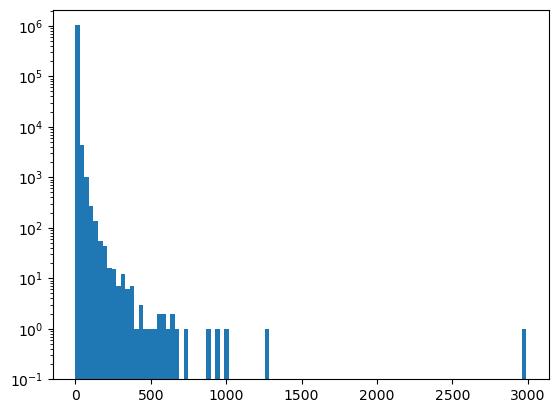

In [61]:
# plot the distribution of score 1
sc1max = int(score1.max())
plt.hist(score1, bins =100, range=(0,sc1max+1))
plt.yscale('log')
plt.ylim(ymin=.1)

2962


(0.1, 2090928.0402556066)

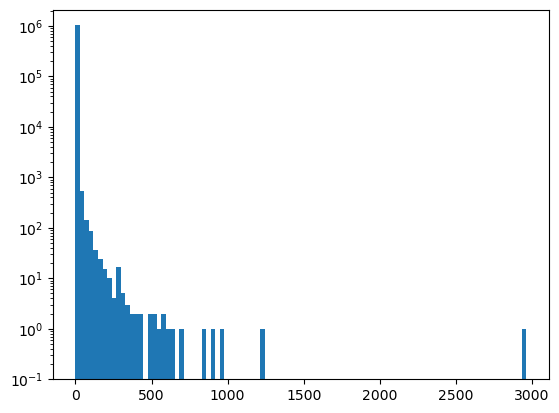

In [62]:
# plot the distribution of score 2
sc2max = int(score2.max())
print(sc2max)
plt.hist(score2, bins =100, range=(0,sc2max+1))
plt.yscale('log')
plt.ylim(ymin=.1)

(array([   59.,   327.,   649.,   983.,  1615.,  2123.,  2686.,  3425.,
         4440.,  5188.,  6040.,  6851.,  8480.,  9738., 10724., 12423.,
        13738., 13920., 15298., 16318., 16759., 17608., 18225., 17999.,
        18229., 18808., 18868., 18536., 18604., 18121., 17039., 16226.,
        15516., 15355., 14052., 13538., 13175., 12439., 11766., 11644.,
        10941., 10722., 10066.,  9814.,  9461.,  8949.,  8881.,  8353.,
         8051.,  7743.,  7575.,  7602.,  8301.,  8496.,  9112.,  9103.,
         9008.,  8473.,  9387.,  9502., 10626., 13023., 13990., 12827.,
        13083., 13204., 12975., 13496., 13922., 13526., 14045., 13820.,
        13338., 12622., 11915., 10907., 10319.,  9028.,  8996.,  8972.,
         8913.,  9031.,  8388.,  7905.,  7751.,  7670.,  7684.,  7998.,
         7599.,  7838.,  8341.,  8115.,  7613.,  7534.,  8058.,  7874.,
         8350., 11921.,  9362.,  6865.]),
 array([   3187.5  ,   13620.785,   24054.07 ,   34487.355,   44920.64 ,
          55353.925, 

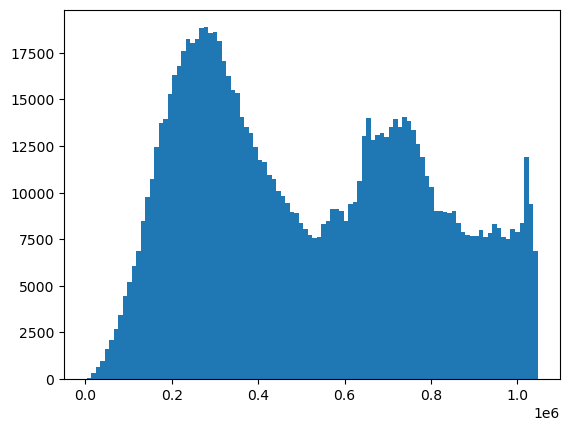

In [63]:
# plot the distribution of final
plt.hist(scores['final'],bins=100)

In [64]:
top_records = scores_sorted.head(ntop).index
print(top_records)

Int64Index([ 917942,  151044, 1059883, 1065870,  665158,   12076,  252834,
             330291,  139726,  665157,
            ...
              88056,   58820,     424,  202498,  938234,     433,   88036,
                436, 1064269,   92650],
           dtype='int64', name='RECORD', length=1000)


In [65]:
# Get the variable dataframe
data_zs['RECORD'] = save_record
data_zs.set_index('RECORD', inplace=True, drop=True)
data_zs.head()

,fullval_ltsize,fullval_bldsize,fullval_bldvol,avland_ltsize,avland_bldsize,avland_bldvol,avtot_ltsize,avtot_bldsize,avtot_bldvol,avland_avland2,...,avland_ltsize_inv_taxclass,avland_bldsize_inv_taxclass,avland_bldvol_inv_taxclass,avtot_ltsize_inv_taxclass,avtot_bldsize_inv_taxclass,avtot_bldvol_inv_taxclass,avland_avland2_inv_taxclass,avtot_avtot2_inv_taxclass,fullval_fullval2_inv_taxclass,value_ratio
RECORD,,,,,,,,,,,,,,,,,,,,,
1,-0.326552,3.406992,0.987422,-0.034199,2.052445,0.766972,-0.041524,1.879522,0.949207,1.305635,...,-0.512577,-0.366754,-0.545038,-0.327433,-0.238511,-0.385804,-0.188608,-0.220809,-1.045024,0.267780
2,108.917366,35.106980,12.980793,61.297815,7.095909,2.734592,128.820205,17.456997,9.068879,1.591891,...,-0.535172,-0.366912,-0.545421,-0.351663,-0.238694,-0.386125,-0.236174,-0.207326,-1.048191,0.188881
9,0.327495,0.197416,-0.471032,0.747304,0.257310,-0.043784,0.729977,0.302327,-0.038185,1.103363,...,-0.532278,-0.365497,-0.513024,-0.349113,-0.237603,-0.368462,-0.145418,-0.107415,-1.029305,0.244919
10,0.653138,0.520331,-0.457550,1.147030,0.398936,-0.037686,1.114097,0.461008,-0.029058,1.103363,...,-0.533182,-0.365953,-0.523024,-0.349904,-0.237946,-0.373909,-0.145418,-0.107415,-1.035235,0.244919
11,1.561562,1.421145,-0.419941,1.215100,0.423053,-0.036648,2.185654,0.903671,-0.003596,1.103363,...,-0.533284,-0.366004,-0.524145,-0.350725,-0.238302,-0.379570,-0.145418,-0.109490,-1.041400,0.200154


In [66]:
# filter the records with top anomaly score
data_zs_top_n = data_zs.loc[top_records]
data_zs_top_n.transpose()

RECORD,917942,151044,1059883,1065870,665158,12076,252834,330291,139726,665157,...,88056,58820,424,202498,938234,433,88036,436,1064269,92650
fullval_ltsize,0.756214,6.052530,204.973756,-0.276342,-0.388437,0.040929,142.219450,-0.220997,256.318188,-0.327127,...,15.172951,22.419631,0.546982,-0.359754,-0.141684,9.359988,11.699290,4.936335,-0.403891,20.269105
fullval_bldsize,68.244847,305.398109,-0.028963,86.959900,133.268367,102.253881,-0.028963,276.362716,-0.028963,103.927531,...,7.577028,11.415466,1.881200,3.947119,15.585728,4.552439,5.815756,7.520252,-0.527895,11.218384
fullval_bldvol,47.353074,105.935454,-0.312537,45.156395,278.798453,214.055711,-0.312537,144.000992,-0.312537,217.549455,...,-0.125335,0.040682,0.127317,8.840342,4.304007,-0.059429,-0.152830,0.120929,-0.501303,0.344217
avland_ltsize,42.183218,2.175770,253.722524,-0.092275,-0.097632,1.367632,176.150190,0.031434,317.190798,0.042458,...,6.059663,18.299761,3.106990,-0.020755,-0.065986,2.579997,10.669875,3.015626,-0.150285,23.795168
avland_bldsize,896.559351,39.323661,0.159563,14.216666,162.835033,125.257416,0.159563,98.346129,0.159563,93.686862,...,1.093729,3.388881,2.887846,4.633198,1.795844,0.446826,1.965549,1.644099,-0.060775,4.800544
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
avtot_bldvol_inv_taxclass,-0.386164,-0.386159,-0.383426,-0.386139,-0.386162,-0.386162,-0.383426,-0.386161,-0.383426,-0.386162,...,-0.384737,-0.385174,-0.385310,-0.386107,-0.386053,-0.384894,-0.384624,-0.385262,8.939205,-0.385529
avland_avland2_inv_taxclass,-0.178970,-0.552470,-0.177891,-0.554458,-0.188473,-0.226291,-0.177891,-0.188871,-0.177891,-0.187119,...,-0.139715,-0.314798,-0.014720,0.079049,-0.154540,-0.104919,-0.163396,-0.089044,-0.192825,-0.145418
avtot_avtot2_inv_taxclass,-0.190312,-0.614614,-0.204933,-0.614974,-0.221043,-0.261443,-0.204933,-0.219977,-0.204933,-0.207607,...,-0.090062,-0.167040,-0.033945,0.002501,-0.163022,-0.125823,-0.219015,-0.064296,-0.225739,-0.186933
fullval_fullval2_inv_taxclass,-1.048380,-1.048538,-1.020585,-1.048264,-1.045988,-1.019477,-1.020585,-1.042942,-1.020585,-1.047866,...,-1.048369,-1.048225,-1.042771,-0.965516,-1.047634,-1.046862,-1.048387,-1.047021,7.848362,-1.048261


In [67]:
# keep the ranks from scores dataframe
scores.set_index('RECORD',inplace=True)
scores.drop(columns=['score1','score2'],inplace=True)
scores.head(30)

,score1 rank,score2 rank,final
RECORD,,,
1,1013699.0,1042337.0,1028018.0
2,1046443.0,1046434.0,1046438.5
9,653362.0,650000.0,651681.0
10,765706.0,818172.0,791939.0
11,911132.0,968251.0,939691.5
12,640091.0,827094.0,733592.5
13,622402.0,683606.0,653004.0
14,622659.0,695461.0,659060.0
15,843388.0,930547.0,886967.5


In [68]:
# combine original data with anomaly score
# you can now find the records you should pay attention easily by rank the anomaly score from high to low

# NY_data_with_scores = NY_data_orig.join(scores, on='RECORD', rsuffix='_scores')
NY_data_with_scores = NY_data_orig.join(scores, on='RECORD')
NY_data_with_scores

,RECORD,BBLE,BORO,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,...,AVTOT2,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE,score1 rank,score2 rank,final
0,1,1000010101,1,1,101,NaN,U S GOVT LAND & BLDGS,P7,4,500,...,8613000.0,3775500.0,8613000.0,NaN,FINAL,2010/11,AC-TR,1013699.0,1042337.0,1028018.0
1,2,1000010201,1,1,201,NaN,U S GOVT LAND & BLDGS,Z9,4,27,...,80690400.0,11111400.0,80690400.0,NaN,FINAL,2010/11,AC-TR,1046443.0,1046434.0,1046438.5
2,3,1000020001,1,2,1,NaN,DEPT OF GENERAL SERVI,Y7,4,709,...,40179510.0,32321790.0,40179510.0,NaN,FINAL,2010/11,AC-TR,NaN,NaN,NaN
3,4,1000020023,1,2,23,NaN,DEPARTMENT OF BUSINES,T2,4,793,...,15750000.0,13644000.0,15750000.0,NaN,FINAL,2010/11,AC-TR,NaN,NaN,NaN
4,5,1000030001,1,3,1,NaN,PARKS AND RECREATION,Q1,4,323,...,107758350.0,106348680.0,107758350.0,NaN,FINAL,2010/11,AC-TR,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1070989,1070990,5080500083,5,8050,83,NaN,"TOBIN, GALE",A1,1,60,...,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR,90856.0,455081.0,272968.5
1070990,1070991,5080500086,5,8050,86,NaN,SHERRI MILINAZZO,A1,1,62,...,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR,606118.0,618971.0,612544.5
1070991,1070992,5080500089,5,8050,89,NaN,JOHN GERVASI,A1,1,53,...,NaN,NaN,NaN,1017.0,FINAL,2010/11,AC-TR,107046.0,712960.0,410003.0
1070992,1070993,5080500092,5,8050,92,NaN,RITA M MOOG,A1,1,52,...,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR,281899.0,792393.0,537146.0


In [69]:
# We only need the top 1000 (you can change the number of record to keep by change ntop)
# to change ntop, go back to the start of part 2.1
NY_data_scored_and_sorted = NY_data_with_scores.sort_values(by=['final','RECORD'], ascending = [False,True])
NY_data_scored_and_sorted.set_index('RECORD',inplace=True)
NY_data_top_n = NY_data_scored_and_sorted.head(ntop)

In [70]:
NY_data_top_n.shape

(1000, 34)

In [71]:
data_zs_top_n.shape

(1000, 97)

In [72]:
# combine the original data with variables
NY_top_with_zs = pd.concat([NY_data_top_n,data_zs_top_n],axis=1)
NY_top_with_zs.shape

(1000, 131)

In [73]:
# save the datasets to files
NY_top_with_zs.to_excel('NY_top_with_zs.xlsx', index=True)
NY_data_top_n.to_excel('NY_top.xlsx', index=True)
data_zs_top_n.to_csv('data_zs_top.csv', index=True)

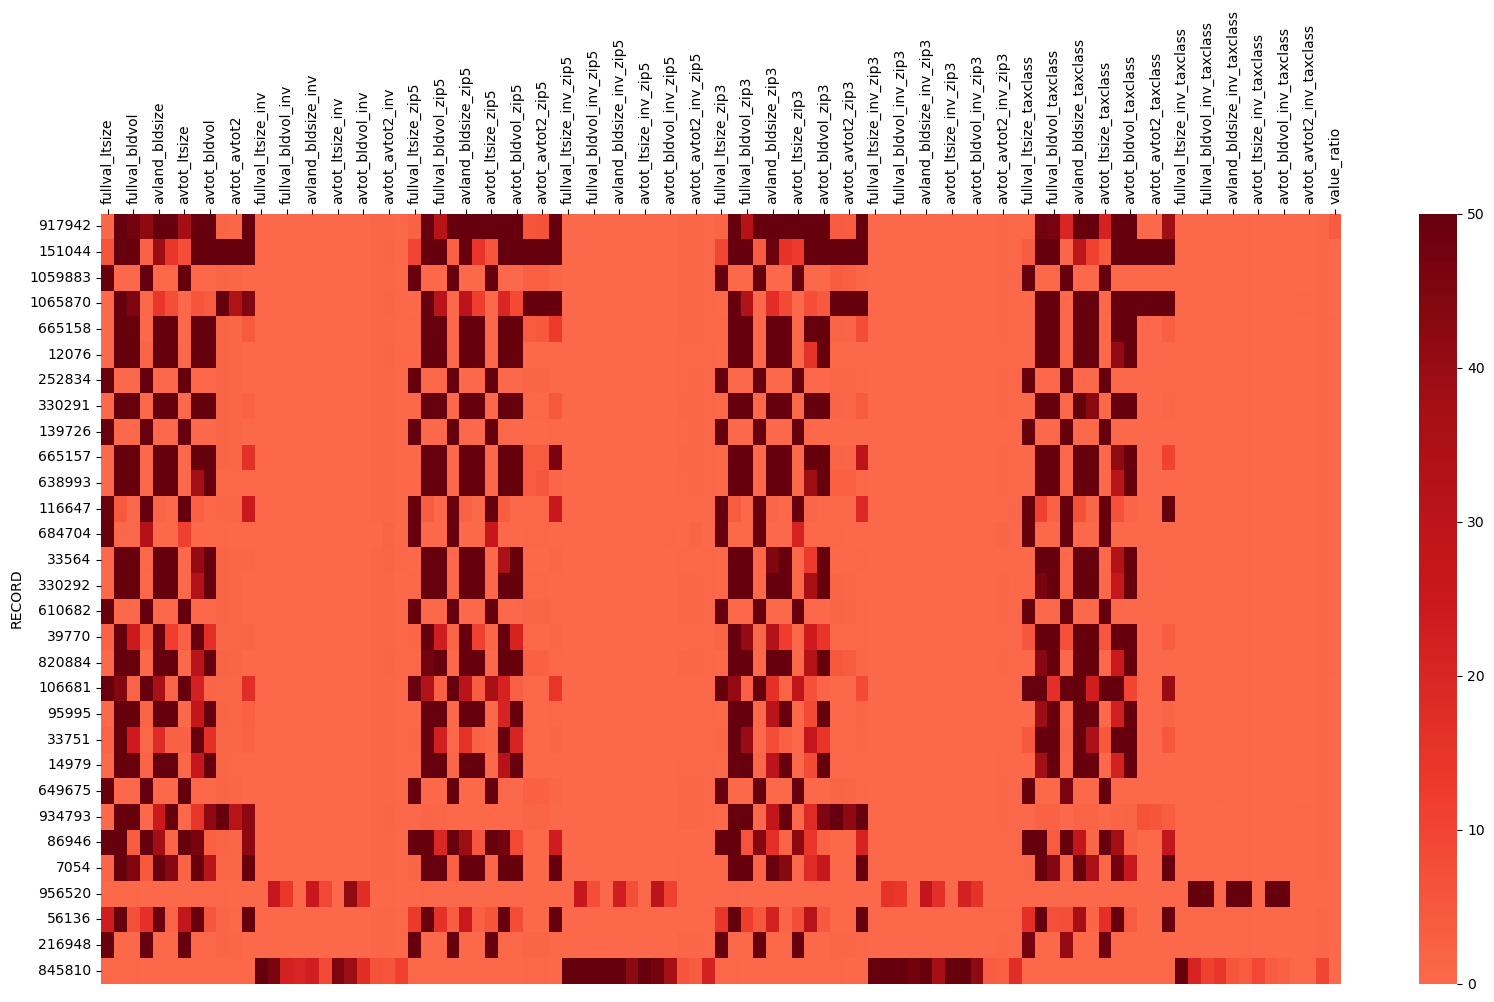

In [74]:
data_zs_top_n_abs = data_zs_top_n.abs()
data_heatmap = data_zs_top_n.abs().head(30)
plt.rcParams['figure.figsize'] = (20,10)
ax = sns.heatmap(data_heatmap, center=0, vmin=0, vmax=50, cmap='Reds')
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
plt.xticks(rotation=90)
plt.savefig('heatmap.png')

In [75]:
# top_records_df = pd.DataFrame(top_records)

In [76]:
# # Use this cell if you want to write out the top n record numbers

# top_records_df.to_csv('top_n_record_numbers.csv', index=False)

In [77]:
# # Use this cell if you want to compare to a previous top n record numbers.
# # You can run a baseline model, see which records score the highest, then change some of the algorithm parameters
# # to see what % of these top scoring records change. The top records are insensitive to changes in the 
# # powers for the Minkowski distance measures for the two scores

# top_records_previous = pd.read_csv('top_n_record_numbers.csv')
# print(top_records_df.head())
# print(top_records_previous.head())
# num_common = len(pd.merge(top_records_df,top_records_previous, on='RECORD'))
# percent_common = 100*num_common/ntop
# percent_common